In [1]:
import torch
import dgl

from gnncloudmanufacturing.data import read_fatahi_dataset, sample_dataset
from gnncloudmanufacturing.mip_solver import mip_solve
from gnncloudmanufacturing.validation import total_cost_from_gamma
from gnncloudmanufacturing.visualization import plot_problem, plot_solution

import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
fatahi_dataset = read_fatahi_dataset('../data/fatahi.xlsx')

  0%|          | 0/18 [00:00<?, ?it/s]

In [16]:
problem = fatahi_dataset[12]
name = problem["name"]
name

'5,20,20-1'

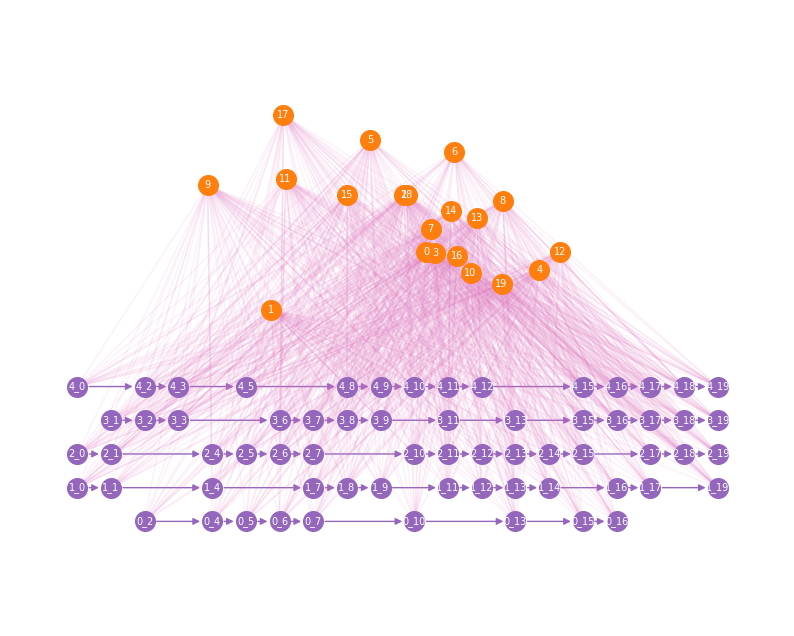

In [17]:
plot_problem(problem)

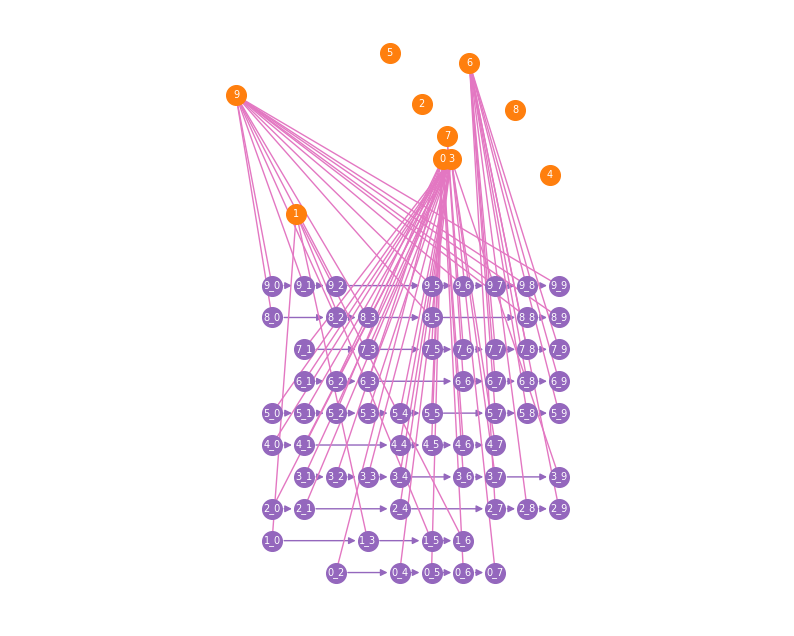

In [12]:
gamma = np.load(f'../data/optimal_solution/{name}/gamma.npy')
plot_solution(problem, gamma)

In [13]:
dataset = sample_dataset(100, [5, 5], [10, 10], [10, 10], 
                         dirpath='../data/', random_seed=0)
len(dataset)

100

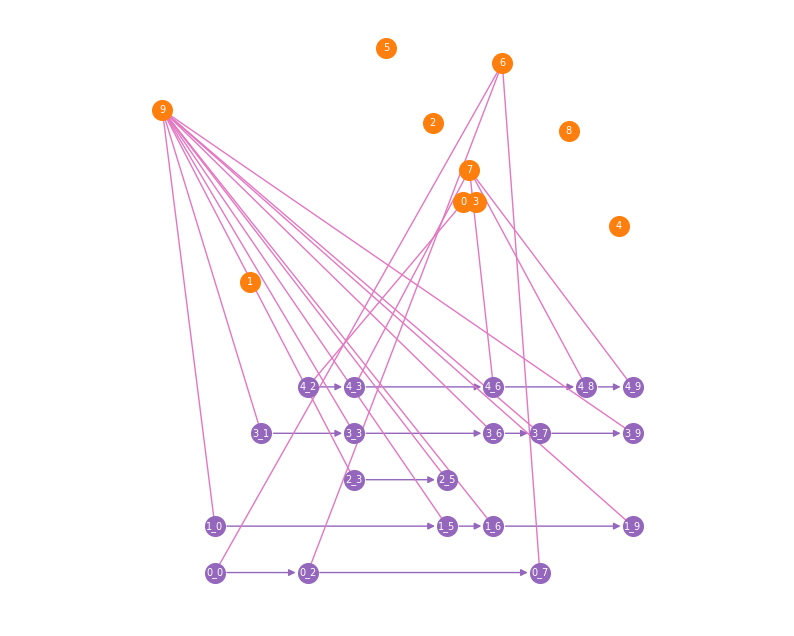

In [15]:
problem = dataset[6]
name = problem['name']
gamma = np.load(f'train_data/optimal/{name}/gamma.npy')
plot_solution(problem, gamma)